<a href="https://colab.research.google.com/github/rballachay/homework/blob/main/COMP551/COMP551_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Dataset

In [ ]:
import tarfile
import pandas as pd
import requests
import os
from pathlib import Path 
import shutil 

URL='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'


# get second dataframe by requests + tar extract
data = requests.get(URL)
with open('aclImdb_v1.tar.gz', 'wb') as f:
    f.write(data.content)

# extract tar file to folder with same name
with tarfile.open('aclImdb_v1.tar.gz') as f:
    f.extractall('./')

shutil.rmtree('aclImdb/train/unsup')

## Define gaussian naive bayes

In [ ]:
import numpy as np

class GaussianNaiveBayes:
    def __init__(self, var_smoothing=1e-9):
        # this is necessary to get good results. it is a way of dealing
        # with variances that are zero, that leads to all NAN in predictions
        self.var_smoothing = var_smoothing

    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        self.mu, self.sigma = np.zeros((C,D)), np.zeros((C,D))
        self.Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            self.Nc[c] = x_c.shape[0]                      #get number of elements of class c
            self.mu[c,:] = np.mean(x_c,0)                  #mean of features of class c
            self.sigma[c,:] = self._vars(x_c, 0)               #std of features of class c
            
        self.pi = (self.Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        
        self.epsilon_ = self.var_smoothing * self._vars(x, axis=0).max()
        self.sigma+=self.epsilon_
        return self

    def predict(self, _x, safe_size):
        l = _x.shape[0]  
        n = int(np.ceil(l/safe_size))

        # using this inner loop to avoiding going dense on
        # all the data at once, and memory problems
        def __inner():
            for i in range(1,n+1):
                x = _x[(i-1)*safe_size:i*safe_size]
                yield self._joint_log_likelihood(x.toarray())
        return np.concatenate(list(__inner()))

    def _joint_log_likelihood(self, X):
        joint_log_likelihood = []
        for i in range(len(self.Nc)):
            jointi = np.log(self.pi[i])
            n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.sigma[i, :]))
            n_ij -= 0.5 * np.sum(((X - self.mu[i, :]) ** 2) / (self.sigma[i, :]), 1)
            joint_log_likelihood.append(jointi + n_ij)
        joint_log_likelihood = np.array(joint_log_likelihood).T
        return joint_log_likelihood

    @staticmethod
    def _vars(a, axis=None):
        """ Variance of sparse matrix a
        var = mean(a**2) - mean(a)**2
        """
        a_squared = a.copy()
        a_squared.data **= 2
        return a_squared.mean(axis) - np.square(a.mean(axis))
        

## Define DataLoader to generate data

In [ ]:
from pathlib import Path
import tensorflow as tf
import torch
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

class DataLoader:
    def __init__(self, path='/content/aclImdb', train='train', test='test', \
                 batch_size=8, tokenizer=None):
        self.batch_size = batch_size
        self.tokenizer = tokenizer

        self._train = self._load(path, train)
        self._test = self._load(path, test)

        # fit count vectorizer, to be used later in generator
        if not tokenizer:
            self.vectorizer = CountVectorizer()
            _, corpus = self._access_data(self._train)
            self.vectorizer.fit(corpus)

    def _load(self, path, subpath):
        _path = Path(path)/subpath
        _ds = tf.keras.preprocessing.text_dataset_from_directory(
            str(_path), 
            batch_size=self.batch_size, 
            seed=0
        )
        return _ds
    
    def unpack_data(self, vectorize=False):
        """data set up to be a generator for BERT model. in the case of
        naive bayes, can just return whole dataset.
        """
        y_train, x_train = self._access_data(self._train)
        y_test, x_test = self._access_data(self._test)

        if vectorize:
            x_train = self.vectorizer.transform(np.array(x_train))
            x_test = self.vectorizer.transform(np.array(x_test))
        return x_train, x_test, y_train, y_test

    def input_generator(self, train=True, untokened=False):
        from keras_preprocessing.sequence import pad_sequences
        
        # generator for x_train data -> choose data source
        if train:
            data_src = self._train
        else:
            data_src = self._test

        for text, label in data_src.as_numpy_iterator(): 
            tokenized = list(map(lambda t: ['[CLS]'] + self.tokenizer.tokenize(str(t))[:510] + ['[SEP]'], text))
            padded = pad_sequences(list(map(self.tokenizer.convert_tokens_to_ids, tokenized)), maxlen=512, truncating="post", padding="post", dtype="int")

            if not untokened:
                yield torch.tensor(padded), torch.tensor([[float(i>0) for i in p] for p in padded]), torch.tensor(label).to(torch.int64)

            else:
                yield torch.tensor(padded), torch.tensor([[float(i>0) for i in p] for p in padded]), torch.tensor(label).to(torch.int64), tokenized, text

    @staticmethod
    def _access_data(source):
        corpus = []
        labels = []
        for text, label in source.as_numpy_iterator(): 
            labels.extend(label.tolist())
            corpus.extend(text.tolist())
        return np.array(labels), corpus

# utility function
def eval_accuracy(y_hat, y):
    if len(y_hat.shape)>1:
        y_hat = np.argmax(y_hat, 1)
    return np.sum(y_hat == y)/y_hat.shape[0]


## Train Naive Gaussian Bayes

In [ ]:
# create generator 
datload = DataLoader()
x_train, x_test, y_train, y_test = datload.unpack_data(vectorize=True)

model = GaussianNaiveBayes()
model.fit(x_train, y_train)

y_hat_train = model.predict(x_train, 5000)
y_hat_test = model.predict(x_test, 5000)

del model # delete immediately to avoid memory problems

# evaluate
accuracy = eval_accuracy(y_hat_test, y_test)
train_acc = eval_accuracy(y_hat_train, y_train)
print(f'test accuracy: {accuracy}, train accuracy: {train_acc}')

# NOTE THAT I TESTED AGAINST THE SKLEARN VERSION AND IT GIVES THE EXACT SAME RESULTS

test accuracy: 0.5724, train accuracy: 0.89188


## Train BERT Model

In [ ]:
!pip install keras_preprocessing
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.1 MB/s eta 0:00:00


In [ ]:
import torch
import gc
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW

gc.collect()
torch.cuda.empty_cache() 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
datload = DataLoader(tokenizer=tokenizer)

config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)  
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
gc.collect()
torch.cuda.empty_cache() 

WEIGHT_DECAY = 0.01 
LR = 2e-5

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)


def train(epoch, loss_vector=None, log_interval=10):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for step, batch in enumerate(datload.input_generator()):

        # Copy data to GPU if needed
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Zero gradient buffers
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        if loss_vector is not None:
            loss_vector.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if step % log_interval == 0:
            print(f'Train Epoch: {epoch} \tLoss: {loss:.6f}')

        if step>500:
          return


def evaluate(train=False):
    model.eval()

    n_correct, n_all = 0, 0
      
    for step, batch in enumerate(datload.input_generator(train=train)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
          outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)
          logits = outputs[0]
        
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        labels = b_labels.to('cpu').numpy()
        n_correct += np.sum(predictions == labels)
        n_all += len(labels)
    
        if step>50:
            print('okay, thats enough data')
            break

    print('Accuracy: [{}/{}] {:.4f}\n'.format(n_correct, n_all, n_correct/n_all))

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# I TRAINED THE MODEL FOR ABOUT 2 EPOCHS ON THE ENTIRE DATASET
'''
test-acc: [0.9159, 0.9327, 0.9255, 0.9279]
val-acc: [0.9928, 0.9904, 0.9904, 0.9904]
'''

EPOCHS = 4

gc.collect()
torch.cuda.empty_cache() 

# Setting hyper-parameters
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    train(epoch, train_lossv)
    print('\nValidation set:')

    # evaluate on testing set
    evaluate(train=False)

    # evaluate on training set 
    evaluate(train=True)

Train Epoch: 1 	Loss: 0.633515
Train Epoch: 1 	Loss: 0.906894
Train Epoch: 1 	Loss: 0.691309
Train Epoch: 1 	Loss: 0.689795
Train Epoch: 1 	Loss: 0.655551
Train Epoch: 1 	Loss: 0.657304
Train Epoch: 1 	Loss: 0.627800
Train Epoch: 1 	Loss: 0.849725
Train Epoch: 1 	Loss: 0.486845
Train Epoch: 1 	Loss: 0.424859
Train Epoch: 1 	Loss: 0.333500
Train Epoch: 1 	Loss: 0.129218
Train Epoch: 1 	Loss: 0.288174
Train Epoch: 1 	Loss: 0.102182
Train Epoch: 1 	Loss: 0.398221
Train Epoch: 1 	Loss: 0.267744
Train Epoch: 1 	Loss: 0.120700
Train Epoch: 1 	Loss: 0.306299
Train Epoch: 1 	Loss: 0.211143
Train Epoch: 1 	Loss: 0.108074
Train Epoch: 1 	Loss: 0.043550
Train Epoch: 1 	Loss: 0.104507
Train Epoch: 1 	Loss: 0.084257
Train Epoch: 1 	Loss: 0.251793
Train Epoch: 1 	Loss: 0.397281
Train Epoch: 1 	Loss: 0.213941
Train Epoch: 1 	Loss: 0.316200
Train Epoch: 1 	Loss: 0.444459
Train Epoch: 1 	Loss: 0.158506
Train Epoch: 1 	Loss: 0.119526
Train Epoch: 1 	Loss: 0.096708
Train Epoch: 1 	Loss: 0.441101
Train Ep

## To be safe, load the model from here

In [ ]:
from google.colab import drive
import pickle

drive.mount('/content/drive/')

# set constants
CACHE_DIR = 'drive/MyDrive/COMP551/A3'

if 'model' in locals():
    with open(f"{CACHE_DIR}/bert_model_trained.pkl",'wb') as _pkl:
        pickle.dump(model, _pkl, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(f"{CACHE_DIR}/bert_model_trained.pkl",'rb') as _pkl:
        model = pickle.load(_pkl)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Plot attention matrix

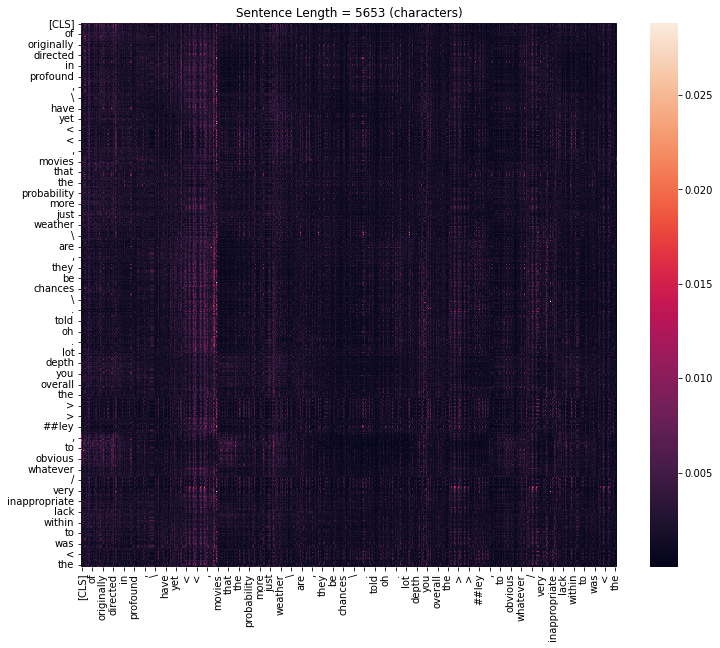

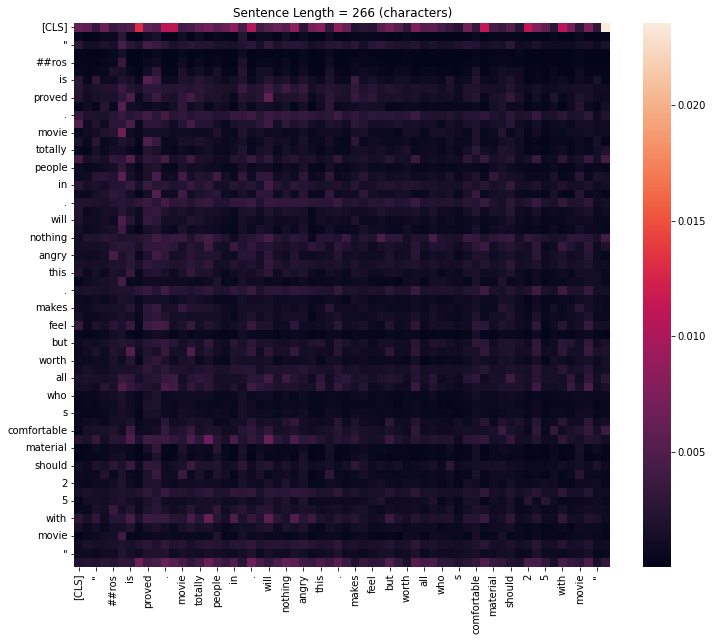

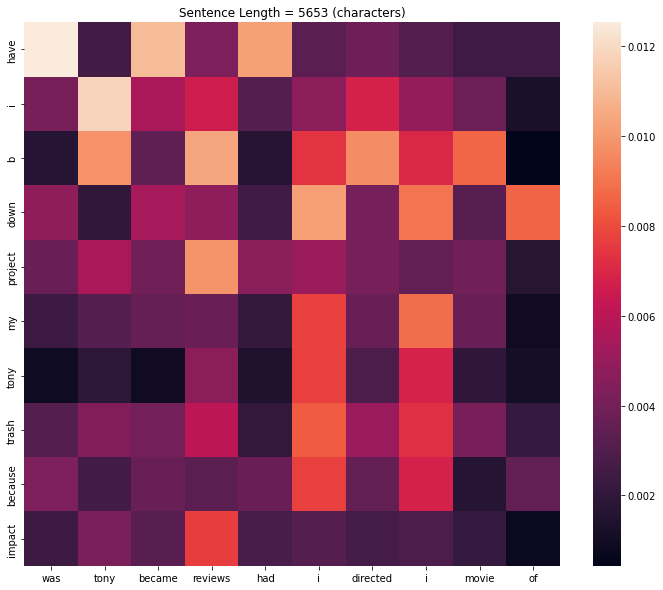

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

with torch.no_grad():
    for step, batch in enumerate(datload.input_generator(train=train, untokened=True)):
        tokens, texts = batch[3:]
        batch = tuple(t.to(device) for t in batch[:3])
        b_input_ids, b_input_mask, b_labels = batch

        out = model(b_input_ids)
        hidden_states = out.hidden_states
        attentions = out.attentions

        logits = out[0].detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        labels = b_labels.to('cpu').numpy()


        isgood = list(labels==predictions)

        # get first of accurate classification
        try:
            first_true=isgood.index(True)
            first_false=isgood.index(False)
        except:
            continue

        # each one of these corresponds to one of the attention heads
        attention_true = attentions[0][first_true,0,...]
        attention_false = attentions[0][first_false,0,...]

        # this is the length of our sentence in tokens, so this is all
        # of the matrix we want to show
        tokens_true = tokens[first_true]
        n_tokens = len(tokens_true)
        att_true_mat = pd.DataFrame(attention_true.detach().cpu().numpy()[:n_tokens,:n_tokens], columns=tokens_true, index=tokens_true)

        # get false tokens
        tokens_false = tokens[first_false]
        n_tokens = len(tokens_false)
        att_false_mat = pd.DataFrame(attention_false.detach().cpu().numpy()[:n_tokens,:n_tokens], columns=tokens_false, index=tokens_false)


        plt.figure(figsize=(12,10))
        sns.heatmap(att_true_mat)
        plt.title(f'Sentence Length = {len(texts[first_true])} (characters)')

        plt.figure(figsize=(12,10))
        sns.heatmap(att_false_mat)
        plt.title(f'Sentence Length = {len(texts[first_false])} (characters)')

        attention_nonames = pd.DataFrame(attention_true.detach().cpu().numpy()[:n_tokens,:n_tokens])
        att_true_mat_reindex = attention_nonames.iloc[attention_nonames.max(axis=1).sort_values(ascending=False).index, attention_nonames.max().sort_values(ascending=False).index]
        att_map = dict(zip(range(len(tokens_true)+1),tokens_true))
        att_true_mat_reindex.columns = list(map(lambda x: att_map[x], att_true_mat_reindex.columns))
        att_true_mat_reindex.index = list(map(lambda x: att_map[x], att_true_mat_reindex.index))
        plt.figure(figsize=(12,10))
        sns.heatmap(att_true_mat_reindex.iloc[:10, :10])
        plt.title(f'Sentence Length = {len(texts[first_true])} (characters)')
        
        break # only going one loop, just want to use generator 